/home/nilspersson/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


silhouette_score: 0.2963268893055335
davies_bouldin_score: 1.3688627541223548


<ipython-input-43-f0ccbc325faa>:56: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  viridis = plt.cm.get_cmap('viridis')


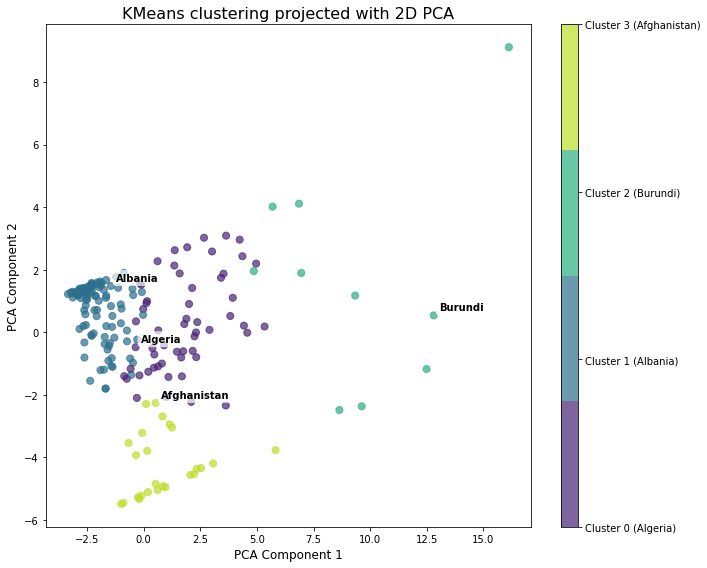

In [43]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import silhouette_score
import numpy as np
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

def evaluate_clusters(metric, data, labels):
    """ Evaluates the clustering results
    
    ---------------
    Note that noise points have to be discarded, can be done via e.g. for model
    model.labels_
    
    mask = model.labels_ != -1
    data = clustering_data[mask]
    labels = model.labels_[mask]
    ---------------
    
    Params:
    metric: 
        a function for measuring cluster quality. E.g. davies_bouldin_score
        
    data: 
        dataframe or numpy array of data
        
    labels: 
        assigned labels by clustering algorightm """
    if len(np.unique(labels)) > 1:
        score = metric(data, labels)
        print(f'{metric.__name__}: {score}')
        return score
    else:
        print('Score cannot be calculated, only one cluster found.')
        
def plot_clusters_2d(model, clustering_data, full_data, noise=False):
    """ Plots the clustering in 2D PCA with improved colormap """
    full_data['Cluster'] = model.labels_
    
    pca = PCA(n_components=2)
    pca_components = pca.fit_transform(clustering_data)
    
    representative_countries = full_data.groupby('Cluster')['Location'].first()
    
    unique_clusters = np.unique(model.labels_)
    num_clusters = len(unique_clusters) - (1 if noise else 0)
    
    # Generate colors using viridis, but avoid white and very light colors
    viridis = plt.cm.get_cmap('viridis')
    cluster_colors = viridis(np.linspace(0.1, 0.9, num_clusters))
    
    if noise:
        # Add gray for noise, ensuring it's the first color
        colors = np.vstack(([0.5, 0.5, 0.5, 1], cluster_colors))
        discrete_cmap = ListedColormap(colors)
        cluster_colors = np.where(model.labels_ == -1, 0, model.labels_ + 1)
    else:
        discrete_cmap = ListedColormap(cluster_colors)
        cluster_colors = model.labels_
    
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(pca_components[:, 0], pca_components[:, 1],
                          c=cluster_colors, cmap=discrete_cmap, s=50,
                          alpha=0.7)
    
    for cluster, country in representative_countries.items():
        if cluster != -1 or not noise:
            idx = full_data[full_data['Location'] == country].index[0]
            x, y = pca_components[idx, 0], pca_components[idx, 1]
            plt.annotate(country, (x, y),
                         xytext=(5, 5), textcoords='offset points',
                         fontsize=10, weight='bold',
                         bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="none", alpha=0.7),
            )
    
    plt.title(f'{type(model).__name__} clustering projected with 2D PCA', fontsize=16)
    plt.xlabel('PCA Component 1', fontsize=12)
    plt.ylabel('PCA Component 2', fontsize=12)
    
    colorbar = plt.colorbar(scatter, aspect=30)
    if noise:
        colorbar.set_ticks(np.arange(len(unique_clusters)))
        colorbar.set_ticklabels(['Noise' if cluster == -1 else f'Cluster {cluster} ({country})' for cluster, country in representative_countries.items()])
    else:
        colorbar.set_ticks(np.arange(num_clusters))
        colorbar.set_ticklabels([f'Cluster {cluster} ({country})' for cluster, country in representative_countries.items()])

    
    plt.tight_layout()
    plt.show()

# Function to process and pivot each dataframe
def process_and_pivot(df, prefix):
    df.fillna(df.mean(numeric_only=True), inplace=True)
    df.fillna("Not Available", inplace=True)
    
    df_filtered = df[['Location', 'Period', 'Value']]
    df_pivoted = df_filtered.pivot(index='Location', columns='Period', values='Value')
    df_pivoted = df_pivoted.rename(columns=lambda x: f"{prefix}_{x}")
    
    return df_pivoted.reset_index()

# Load the datasets
advertisingBan = pd.read_csv('../data/advertising_ban_internet.csv')
affordability = pd.read_csv('../data/affordability.csv')
gdp2000Cigs = pd.read_csv('../data/gdp_for_2000_cigs.csv')
healthWarningPhoto = pd.read_csv('../data/health_warning_photo.csv')
requiredHealthWarnings = pd.read_csv('../data/required_health_warning.csv')

# Process and pivot each dataframe
advertisingBan_pivoted = process_and_pivot(advertisingBan, 'advertisingBan')
affordability_pivoted = process_and_pivot(affordability, 'affordability')
gdp2000Cigs_pivoted = process_and_pivot(gdp2000Cigs, 'gdp2000Cigs')
healthWarningPhoto_pivoted = process_and_pivot(healthWarningPhoto, 'healthWarningPhoto')
requiredHealthWarnings_pivoted = process_and_pivot(requiredHealthWarnings, 'requiredHealthWarnings')

# Merge the pivoted dataframes on 'Location'
combined_df = advertisingBan_pivoted.merge(affordability_pivoted, on='Location', how='outer')
combined_df = combined_df.merge(gdp2000Cigs_pivoted, on='Location', how='outer')
combined_df = combined_df.merge(healthWarningPhoto_pivoted, on='Location', how='outer')
combined_df = combined_df.merge(requiredHealthWarnings_pivoted, on='Location', how='outer')

# Drop 'Location' for clustering
data_for_clustering = combined_df.drop(columns=['Location'])

# Preprocessing pipeline: imputing, encoding, and scaling
numeric_features = data_for_clustering.select_dtypes(include=['float64', 'int64']).columns
categorical_features = data_for_clustering.select_dtypes(include=['object']).columns

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Prepare the final data for clustering
clustering_data = preprocessor.fit_transform(data_for_clustering)

# Apply K-means clustering
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(clustering_data)

mask = kmeans.labels_ != -1
data = clustering_data[mask]
labels = kmeans.labels_[mask]

evaluate_clusters(silhouette_score, data, labels)
evaluate_clusters(davies_bouldin_score, data, labels)

plot_clusters_2d(kmeans, clustering_data, combined_df)


In [44]:
# Find all the countries in each cluster
combined_df['Cluster'] = kmeans.labels_
countries_in_clusters = combined_df.groupby('Cluster')['Location'].apply(list)

print("Countries in each cluster:")
for cluster, countries in countries_in_clusters.items():
    print(f"Cluster {cluster}: {countries}")

Countries in each cluster:
Cluster 0: ['Algeria', 'Bahamas', 'Belize', 'Benin', 'Bhutan', 'Burkina Faso', 'Cabo Verde', 'Cameroon', 'Central African Republic', 'Chad', 'Comoros', 'Congo', 'Cook Islands', "Cote d'Ivoire", 'Cuba', "Democratic People's Republic of Korea", 'Democratic Republic of the Congo', 'Dominican Republic', 'Eswatini', 'Ethiopia', 'Fiji', 'Gambia', 'Guatemala', 'Guinea', 'Honduras', 'India', 'Jamaica', 'Kenya', 'Mali', 'Marshall Islands', 'Morocco', 'Mozambique', 'Nauru', 'Nicaragua', 'Niger', 'Rwanda', 'Samoa', 'Senegal', 'Solomon Islands', 'Sri Lanka', 'Sudan', 'Syrian Arab Republic', 'Tajikistan', 'Timor-Leste', 'Togo', 'Tonga', 'Tunisia', 'Turkmenistan', 'Tuvalu', 'Uganda', 'United Republic of Tanzania', 'Uzbekistan', 'Yemen', 'Zambia', 'Zimbabwe', 'occupied Palestinian territory, including east Jerusalem']
Cluster 1: ['Albania', 'Argentina', 'Armenia', 'Australia', 'Austria', 'Azerbaijan', 'Bahrain', 'Bangladesh', 'Belarus', 'Belgium', 'Bolivia (Plurinational St

In [46]:
import pandas as pd

# Load the dataset
ageStandardUse = pd.read_csv('../data/age_stand.csv')

# Aggregate the data to handle duplicates
ageStandardUse_aggregated = ageStandardUse.groupby(['Location', 'Period'])['Value'].mean().reset_index()

# Pivot the data
ageStandardUse_pivoted = ageStandardUse_aggregated.pivot(index='Location', columns='Period', values='Value')

# Reset the index to make 'Location' a column again
ageStandardUse_pivoted = ageStandardUse_pivoted.reset_index()

# Display the pivoted DataFrame
print(ageStandardUse_pivoted)

ValueError: Index contains duplicate entries, cannot reshape